# Phase2Pro - Iteration 5

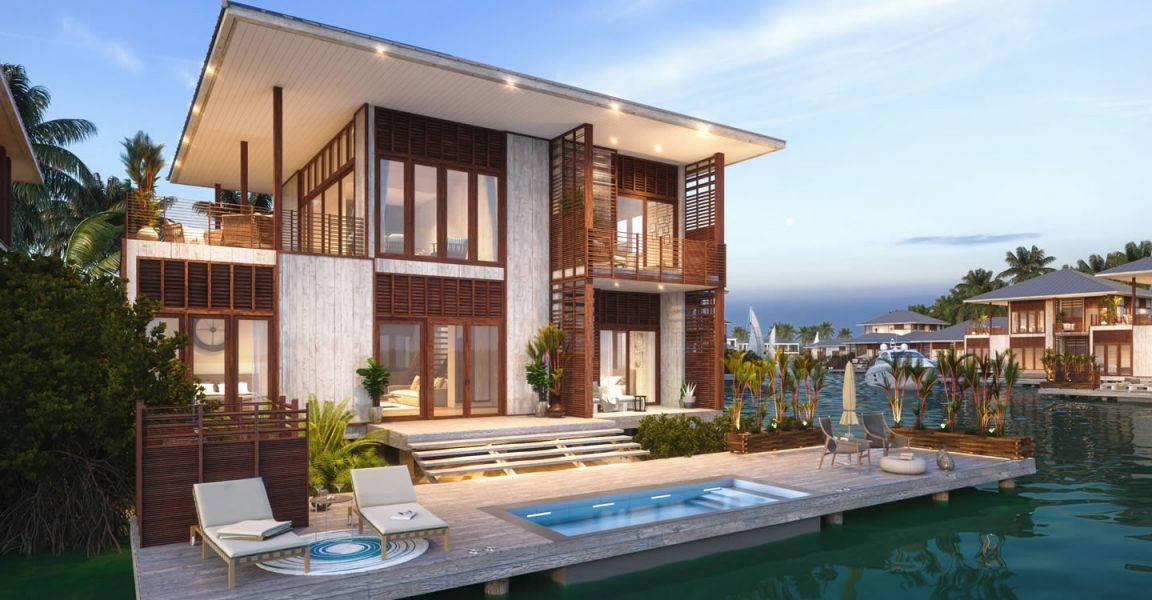

#BUSINESS PROBLEM: 


#Using OESMIN Model for Data Science Process

#Obtain: 

In [63]:
#Import packages
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import scipy.stats as stats
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import random
import math 
import logging
import seaborn as sns
plt.style.use('seaborn')

In [64]:
#Import data set
df = pd.read_csv('data\\kc_house_data.csv')
#refined dataset and drop unnecessary column data
df.drop(['id', 'date', 'waterfront', 'sqft_above', 'sqft_basement', 'lat', 'long', 'view', 'sqft_living15', 'sqft_lot15', 'waterfront', 'yr_renovated'], axis=1, inplace=True)
#incorporated lamda to reduce exponential value occurence in describe data below ()
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if int(x) == x else '{:,.2f}'.format(x) 

##DATA: 

#Scrub: During this stage, we'll focus on preprocessing our data. Important steps such as identifying and removing null values, dealing with outliers, normalizing data, and feature engineering/feature selection are handled around this stage. The line with this stage really blurs with the Explore stage, as it is common to only realize that certain columns require cleaning or preprocessing as a result of the visualizations and explorations done during Step 3.

#Note that although technically, categorical data should be one-hot encoded during this step, in practice, it's usually done after data exploration. This is because it is much less time-consuming to visualize and explore a few columns containing categorical data than it is to explore many different dummy columns that have been one-hot encoded.

In [66]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['bedrooms','sqft_lot','price','sqft_living','bathrooms']], 
                 hue='sqft_living', palette='tab20',height=6)
g.set(xticklabels=[]);

In [11]:
#create the column data
continuous = ['price', 'bedrooms', 'bathrooms', 'grade']
categoricals = ['sqft_living', 'sqft_lot', 'yr_built', 'zipcode', 'floors', 'condition']
df_cont = df[continuous]

In [12]:
# log features
log_names = [f'{column}_log' for column in df_cont.columns]
df_log = np.log(df_cont)
df_log.columns = log_names

In [13]:
#correcting datatypes and describing without exponential ramifications
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if int(x) == x else '{:,.2f}'.format(x) 
df.describe()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
count      21597     21597      21597        21597     21597   21597   
mean  540,296.57      3.37       2.12     2,080.32 15,099.41    1.49   
std   367,368.14      0.93       0.77       918.11 41,412.64    0.54   
min        78000         1       0.50          370       520       1   
25%       322000         3       1.75         1430      5040       1   
50%       450000         3       2.25         1910      7618    1.50   
75%       645000         4       2.50         2550     10685       2   
max      7700000        33          8        13540   1651359    3.50   

       condition  grade  yr_built   zipcode  
count      21597  21597     21597     21597  
mean        3.41   7.66  1,971.00 98,077.95  
std         0.65   1.17     29.38     53.51  
min            1      3      1900     98001  
25%            3      7      1951     98033  
50%            3      7      1975     98065  
75%            4      8      1997     98118  
max            5     13      2015     98199

In [14]:
# normalize (subract mean and divide using std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
df_log_norm = df_log.apply(normalize)

In [15]:
# one hot encode categoricals
df_ohe = pd.get_dummies(df[categoricals], prefix=categoricals[0], drop_first=True)
preprocessed = pd.concat([df_log_norm, df_ohe], axis=1)
X = preprocessed.drop('sqft_living', axis=1)
y = preprocessed['sqft_living']

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [18]:
# A brief preview of train-test split to create test training data and dummy data set
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [19]:
#apply model to the train set 
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [20]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error
test_residuals = y_hat_test - y_test
test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

225859.30685472654

In [21]:
##Explore:  the data set by deriving statistics and creating visualisation iwth dummy test data
#Further understanding the data 

In [22]:
# Force data as pandas DataFrame
def kfolds(data, k):
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size          
    return folds 

In [23]:
df_data = pd.concat([X.reset_index(drop=True), y], axis=1)

In [24]:
df_folds = kfolds(df_data, 5)

In [25]:
test_errs = []
train_errs = []
k=5
for n in range(k):
    # Split in train and test for the fold
    train = pd.concat([fold for i, fold in enumerate(df_folds) if i!=n])
    test = df_folds[n]
    # Fit a linear regression model
    linreg.fit(X_train, y_train)
    #Evaluate Train and Test Errors
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test
    train_errs.append(np.mean(train_residuals.astype(float)**2))
    test_errs.append(np.mean(test_residuals.astype(float)**2))
print(train_errs)
print(test_errs)

[222641.7893125034, 222641.7893125034, 222641.7893125034, 222641.7893125034, 222641.7893125034]
[225859.30685472646, 225859.30685472646, 225859.30685472646, 225859.30685472646, 225859.30685472646]


In [26]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)

In [27]:
cv_5_results.mean()

226852.97450995035

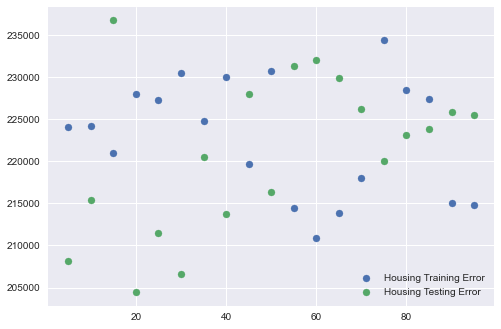

In [28]:
import random
random.seed(110)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Housing Training Error')
plt.scatter(t_sizes, test_err, label='Housing Testing Error')
plt.legend()

Null hypothesis:
There is no difference between experimental and control group 
𝜇1=𝜇2μ1=μ2

Alternative Hypothesis:
There is a difference between experimental and control group 
𝜇1≠𝜇2μ1≠μ2


In [29]:
#Paired sample t-test (although data set is over 30)- exploration

df = pd.read_csv('data\\kc_house_data.csv')
df[['price','sqft_living']].describe()
ttest,pval = stats.ttest_rel(df['price'], df['sqft_living'])
print(pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

0.0
reject null hypothesis


In [30]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
df_log_norm = df_log.apply(normalize)

In [31]:
# one hot encode categoricals with dummy categoricals
df_ohe = pd.get_dummies(df[categoricals], prefix=categoricals[0], drop_first=True)
preprocessed = pd.concat([df_log_norm, df_ohe], axis=1)
X = preprocessed.drop('sqft_living', axis=1)
y = preprocessed['sqft_living']

In [32]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [33]:
# A brief preview of train-test split samples
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [34]:
#from sklearn.linear_model import LinearRegression

In [35]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [36]:
test_residuals = y_hat_test - y_test
test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

213577.55701936048

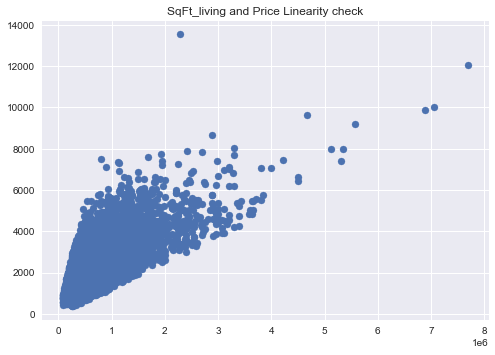

In [37]:
#create a scatter plot to check linearity
plt.scatter(df.price, df.sqft_living)
plt.title("SqFt_living and Price Linearity check")
plt.show()


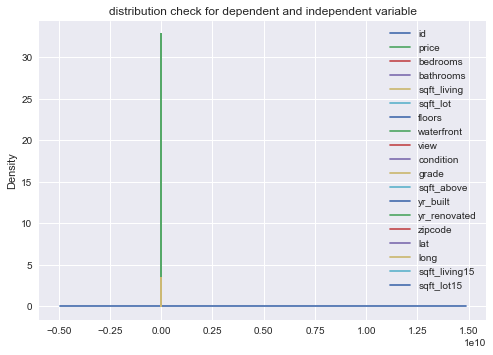

In [38]:
#kernal density plot estimation and distro check
df.plot.kde()
plt.title("distribution check for dependent and independent variable")
plt.show()

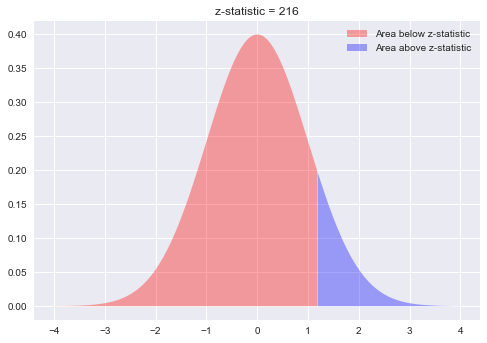

In [39]:
#Visualize z-statistics
plt.fill_between(x=np.arange(-4,1.19,0.01),
                 y1= stats.norm.pdf(np.arange(-4,1.19,0.01)) ,
                 facecolor='red',
                 alpha=0.35,
                 label= 'Area below z-statistic'
                 )

plt.fill_between(x=np.arange(1.19,4,0.01), 
                 y1= stats.norm.pdf(np.arange(1.19,4,0.01)) ,
                 facecolor='blue',
                 alpha=0.35, 
                 label= 'Area above z-statistic')
plt.legend()
plt.title ('z-statistic = 216');

In [40]:
#Calculate p-value 
stats.norm.cdf(216)

1.0

In [41]:
#display pval with degree of freedon
pval = 1 - stats.norm.cdf(216)
pval

0.0

In [42]:
#clean data review 
df.head()

id        date  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7129300520  10/13/2014 221900         3          1         1180      5650   
1  6414100192   12/9/2014 538000         3       2.25         2570      7242   
2  5631500400   2/25/2015 180000         2          1          770     10000   
3  2487200875   12/9/2014 604000         4          3         1960      5000   
4  1954400510   2/18/2015 510000         3          2         1680      8080   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement yr_built  \
0       1         NaN     0  ...      7        1180            0.0     1955   
1       2           0     0  ...      7        2170          400.0     1951   
2       1           0     0  ...      6         770            0.0     1933   
3       1           0     0  ...      7        1050          910.0     1965   
4       1           0     0  ...      8        1680            0.0     1987   

   yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  
0             0    98178 47.51 -122.26           1340        5650  
1          1991    98125 47.72 -122.32           1690        7639  
2           NaN    98028 47.74 -122.23           2720        8062  
3             0    98136 47.52 -122.39           1360        5000  
4             0    98074 47.62 -122.05           1800        7503  

[5 rows x 21 columns]

In [43]:
#Show unique values for column data
df.nunique()

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

In [44]:
#Enter in code for z test score 
import scipy.stats as stats
from math import sqrt
x_bar = 540296 # sample mean 
n =  21597# number of count
sigma = 367368 # sd of population
mu = 25 # Population mean 
z = (x_bar - mu)/(sigma/sqrt(n))
z

216.12601549430946

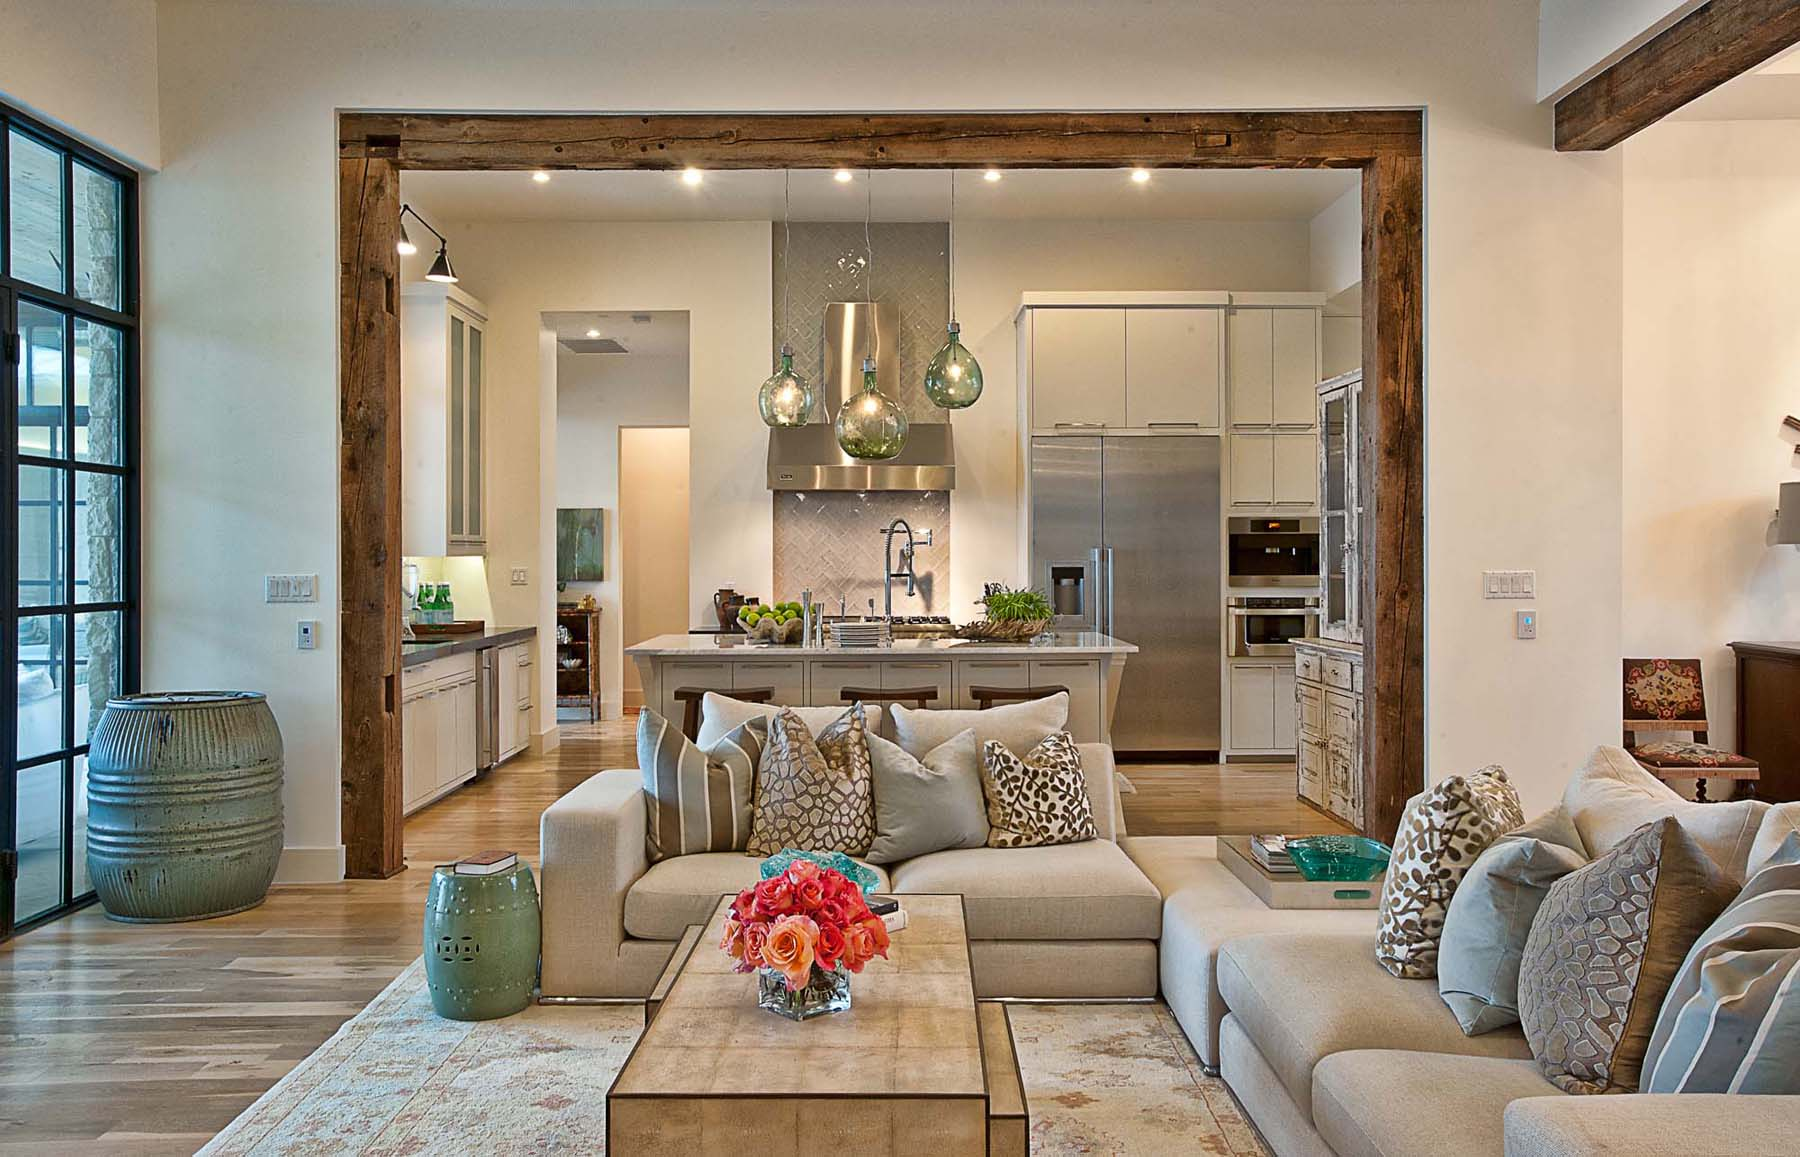

In [45]:
#Note that the bedrooms, grade, sqft_lot are variables that remain closest to our alpha values. 

In [46]:
#creating the variable called model ; to create the best line of fit - we are passing the regression 
#Y is our dependant variable #X is independent variable 
f = 'price~sqft_living'
model = ols(formula=f, data=df).fit()
#prompt for mod summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Sun, 22 May 2022   Prob (F-statistic):               0.00
Time:                        21:14:05   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that the R squared value is between 0  and 1 with a value of 0.493. This is a great sign that the "sqft_living" coefficient has a strong relationship to sale price. This info will add value to further research regarding understanding the relationships connecting Kings County homebuyers' requirements of buying a property. 

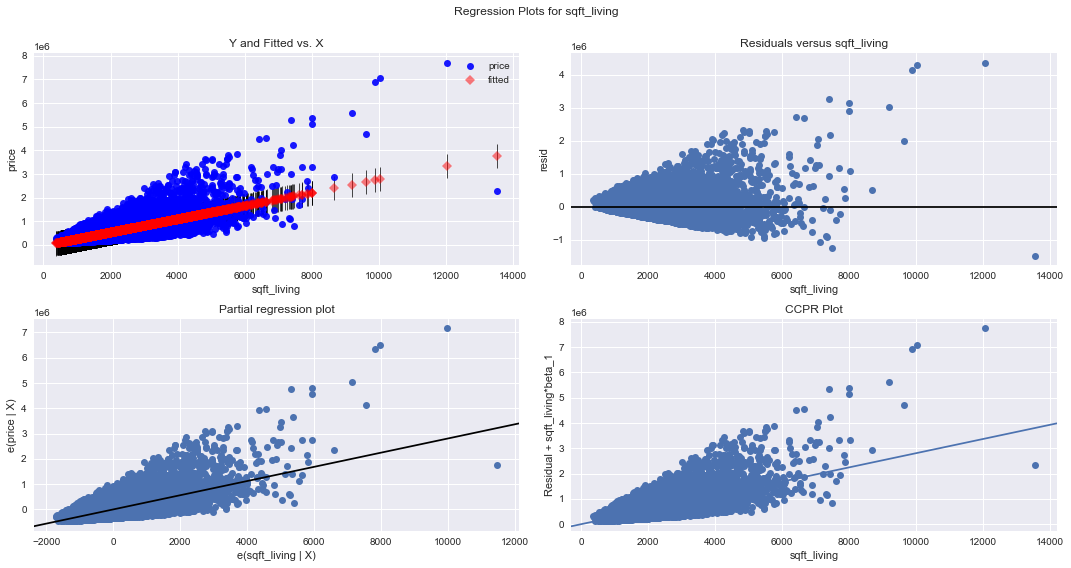

In [47]:
#visualisation used to model and interpret the data 
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

C:\Users\racar\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\racar\AppData\Local\Temp/ipykernel_19248/1081638490.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


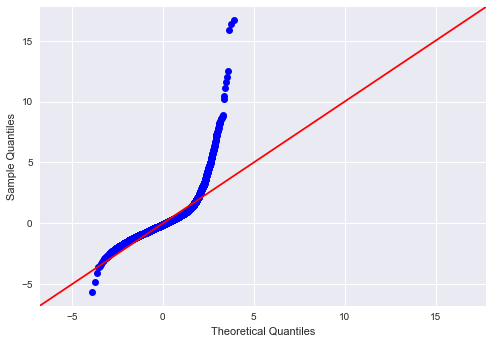

In [48]:
#import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

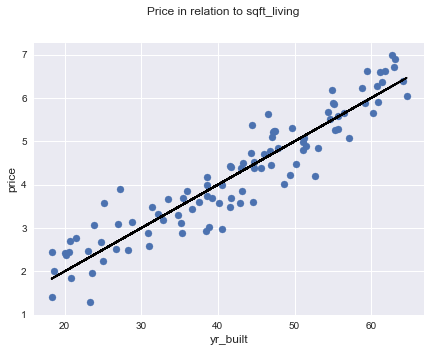

In [49]:
#Visualize price of houses in relation to sqft_living
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)
sen = np.random.uniform(18, 65, 100)
income = np.random.normal((sen/10), 0.5)
sen = sen.reshape(-1, 1)

fig = plt.figure(figsize=(7, 5))
fig.suptitle('Price in relation to sqft_living', fontsize=12)
plt.scatter(sen, income)
plt.plot(sen, sen/10, c='black')
plt.xlabel('yr_built', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

In [50]:
#
data_pred = df.iloc[:,0:12]
data_pred.head()

id        date  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7129300520  10/13/2014 221900         3          1         1180      5650   
1  6414100192   12/9/2014 538000         3       2.25         2570      7242   
2  5631500400   2/25/2015 180000         2          1          770     10000   
3  2487200875   12/9/2014 604000         4          3         1960      5000   
4  1954400510   2/18/2015 510000         3          2         1680      8080   

   floors  waterfront  view  condition  grade  
0       1         NaN     0          3      7  
1       2           0     0          3      7  
2       1           0     0          3      6  
3       1           0     0          5      7  
4       1           0     0          3      8

In [51]:
#
data_pred.corr()

id  price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id              1  -0.02      0.00       0.01        -0.01     -0.13    0.02   
price       -0.02      1      0.31       0.53         0.70      0.09    0.26   
bedrooms     0.00   0.31         1       0.51         0.58      0.03    0.18   
bathrooms    0.01   0.53      0.51          1         0.76      0.09    0.50   
sqft_living -0.01   0.70      0.58       0.76            1      0.17    0.35   
sqft_lot    -0.13   0.09      0.03       0.09         0.17         1   -0.00   
floors       0.02   0.26      0.18       0.50         0.35     -0.00       1   
waterfront  -0.00   0.28     -0.00       0.07         0.11      0.02    0.02   
view         0.01   0.40      0.08       0.19         0.28      0.08    0.03   
condition   -0.02   0.04      0.03      -0.13        -0.06     -0.01   -0.26   
grade        0.01   0.67      0.36       0.67         0.76      0.11    0.46   

             waterfront  view  condition  grade  
id                -0.00  0.01      -0.02   0.01  
price              0.28  0.40       0.04   0.67  
bedrooms          -0.00  0.08       0.03   0.36  
bathrooms          0.07  0.19      -0.13   0.67  
sqft_living        0.11  0.28      -0.06   0.76  
sqft_lot           0.02  0.08      -0.01   0.11  
floors             0.02  0.03      -0.26   0.46  
waterfront            1  0.41       0.02   0.09  
view               0.41     1       0.05   0.25  
condition          0.02  0.05          1  -0.15  
grade              0.09  0.25      -0.15      1

In [52]:
#
abs(data_pred.corr()) > 0.75

id  price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id            True  False     False      False        False     False   False   
price        False   True     False      False        False     False   False   
bedrooms     False  False      True      False        False     False   False   
bathrooms    False  False     False       True         True     False   False   
sqft_living  False  False     False       True         True     False   False   
sqft_lot     False  False     False      False        False      True   False   
floors       False  False     False      False        False     False    True   
waterfront   False  False     False      False        False     False   False   
view         False  False     False      False        False     False   False   
condition    False  False     False      False        False     False   False   
grade        False  False     False      False         True     False   False   

             waterfront   view  condition  grade  
id                False  False      False  False  
price             False  False      False  False  
bedrooms          False  False      False  False  
bathrooms         False  False      False  False  
sqft_living       False  False      False   True  
sqft_lot          False  False      False  False  
floors            False  False      False  False  
waterfront         True  False      False  False  
view              False   True      False  False  
condition         False  False       True  False  
grade             False  False      False   True

In [53]:
#Cleaning data 
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous
df.drop_duplicates(inplace=True)

In [54]:
df[(df.cc>.75) & (df.cc <1)]

cc
pairs                        
(grade, sqft_living)     0.76
(sqft_living, bathrooms) 0.76

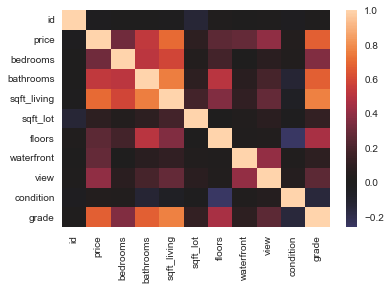

In [55]:
import seaborn as sns
sns.heatmap(data_pred.corr(), center=0);

Each square shows the correlation between the variables on each axis. Correlation ranges from -2 to +1. Data closer to zero means there is no linear relationship between the two variables.

In [ ]:
#Explanation of findings 
# As a predictor, radio performs worse than TV. 
# It has higher amount of skewness and kurtosis than TV. After running the model, it also became clear that 
# the residuals QQ plot looks off, so the normality assumption is not fulfilled.
# A very low R_squared explaining only 33% of variance in the target variable.

# A "unit" increase in radio spending is associated with a 0.2025 "unit" increase in Sales.
# OR An additional 1,000 spent on TV is associated with an increase in sales of 202.5

# There is obvious heteroscedasticity as with the case of TV.
